In [ ]:
"""
Support Vector Machine Hyperparameter Tuning Example
====================================================

This script demonstrates how to:
1. Load and prepare data
2. Optimize SVM hyperparameters using GridSearchCV
3. Evaluate the best model's performance
4. Visualize decision boundaries (for 2D data)
"""

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.pipeline import Pipeline
import seaborn as sns

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

def load_data(use_synthetic=False):
    """
    Load either real-world or synthetic dataset
    """
    if use_synthetic:
        # Create a synthetic dataset for visualization purposes (2D)
        X, y = make_classification(
            n_samples=300, 
            n_features=2,
            n_redundant=0, 
            n_informative=2,
            random_state=42,
            n_clusters_per_class=1
        )
        feature_names = [f'Feature {i+1}' for i in range(2)]
        target_names = ['Class 0', 'Class 1']
    else:
        # Load breast cancer dataset
        dataset = load_breast_cancer()
        X, y = dataset.data, dataset.target
        feature_names = dataset.feature_names
        target_names = dataset.target_names
    
    return X, y, feature_names, target_names

In [3]:
def create_svm_pipeline():
    """
    Create a pipeline with standardization and SVM
    """
    return Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True))
    ])

In [4]:
def grid_search_svm(X_train, y_train):
    """
    Perform grid search to find the best SVM hyperparameters
    """
    # Create pipeline
    pipeline = create_svm_pipeline()
    
    # Define hyperparameter grid
    param_grid = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': [0.001, 0.01, 0.1, 1],
        'svm__kernel': ['rbf', 'linear', 'poly']
    }
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    return grid_search

In [5]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Generate classification report
    report = classification_report(y_test, y_pred)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    return accuracy, report, conf_matrix

In [6]:
def visualize_decision_boundary(model, X, y, feature_names):
    """
    Visualize the decision boundary (only for 2D data)
    """
    if X.shape[1] != 2:
        print("Decision boundary visualization requires 2D data")
        return
    
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Predict class labels for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary and data points
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title("SVM Decision Boundary")
    plt.colorbar(scatter, label='Class')
    plt.tight_layout()
    plt.savefig('svm_decision_boundary.png')
    plt.close()

In [7]:
def visualize_hyperparameter_performance(grid_search):
    """
    Visualize the performance of different hyperparameter combinations
    """
    # Extract results into a DataFrame
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Create a pivot table for C and gamma (for rbf kernel)
    rbf_results = results[results['param_svm__kernel'] == 'rbf'].copy()
    
    if not rbf_results.empty:
        pivot_table = rbf_results.pivot_table(
            index='param_svm__gamma', 
            columns='param_svm__C',
            values='mean_test_score'
        )
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_table, annot=True, cmap='viridis')
        plt.title('SVM Hyperparameter Performance (RBF Kernel)')
        plt.xlabel('C')
        plt.ylabel('Gamma')
        plt.tight_layout()
        plt.savefig('svm_hyperparameter_performance.png')
        plt.show()
        plt.close()
    
    # Compare kernel performance
    kernel_performance = results.groupby('param_svm__kernel')['mean_test_score'].mean()
    
    plt.figure(figsize=(8, 6))
    kernel_performance.plot(kind='bar')
    plt.title('Average Performance by Kernel Type')
    plt.xlabel('Kernel')
    plt.ylabel('Mean CV Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('svm_kernel_performance.png')
    plt.show()
    plt.close()

Dataset shape: (569, 30)
Number of classes: 2
Starting grid search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters found:
svm__C: 0.1
svm__gamma: 0.001
svm__kernel: linear

Test accuracy: 0.9825

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        43
           1       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114


Confusion matrix:
[[41  2]
 [ 0 71]]


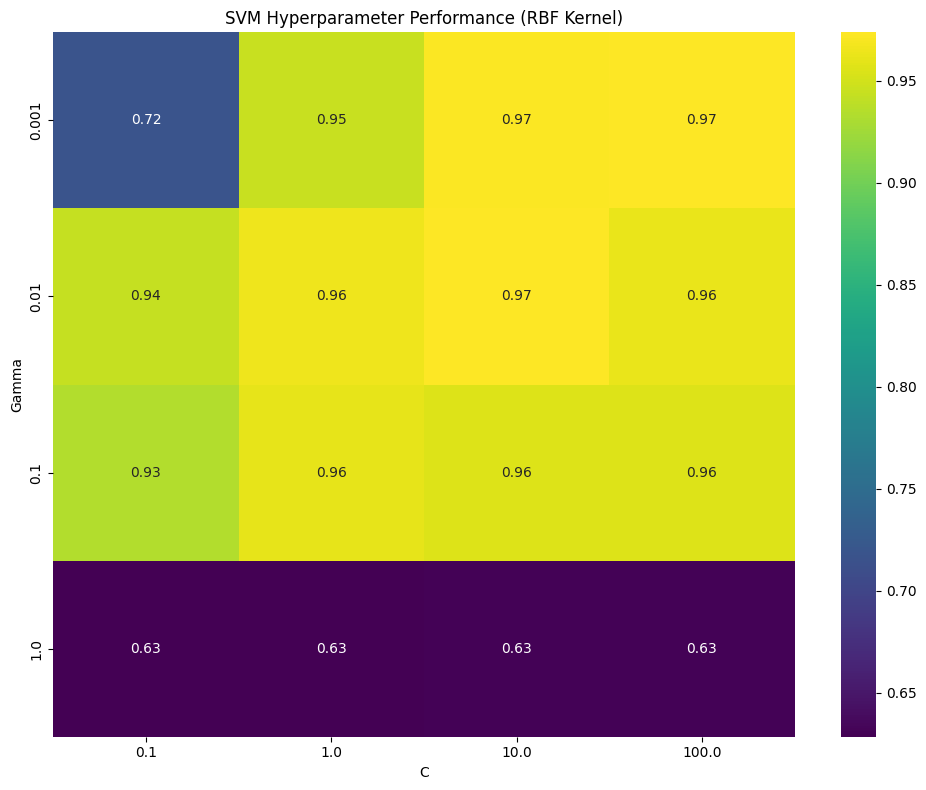

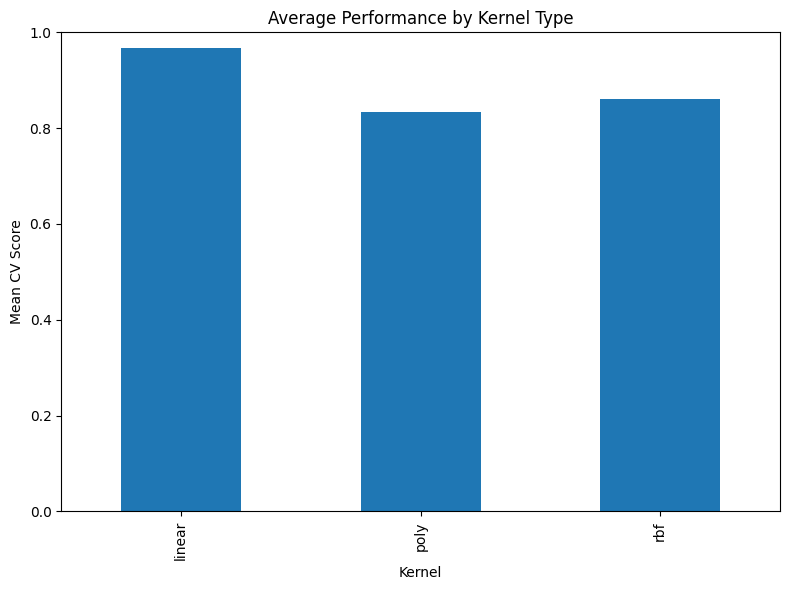


Creating 2D synthetic dataset for decision boundary visualization...
Decision boundary visualized and saved as 'svm_decision_boundary.png'


In [8]:
def main():
    # Load data (set use_synthetic=True for 2D visualization)
    X, y, feature_names, target_names = load_data(use_synthetic=False)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"Dataset shape: {X.shape}")
    print(f"Number of classes: {len(np.unique(y))}")
    
    # Perform grid search
    print("Starting grid search...")
    grid_search = grid_search_svm(X_train, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print("\nBest parameters found:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    
    # Evaluate model
    accuracy, report, conf_matrix = evaluate_model(best_model, X_test, y_test)
    
    print(f"\nTest accuracy: {accuracy:.4f}")
    print("\nClassification report:")
    print(report)
    
    print("\nConfusion matrix:")
    print(conf_matrix)
    
    # Visualize hyperparameter performance
    visualize_hyperparameter_performance(grid_search)
    
    # If using 2D data, visualize decision boundary
    if X.shape[1] == 2:
        visualize_decision_boundary(best_model, X, y, feature_names)
        print("\nDecision boundary visualized and saved as 'svm_decision_boundary.png'")
    
    # For additional analysis, let's use a different dataset to demonstrate decision boundary
    if X.shape[1] != 2:
        print("\nCreating 2D synthetic dataset for decision boundary visualization...")
        X_2d, y_2d, feature_names_2d, _ = load_data(use_synthetic=True)
        
        # Create and train a simplified model for visualization
        pipeline_2d = create_svm_pipeline()
        # Properly set parameters for pipeline components
        pipeline_2d.set_params(**{k: v for k, v in best_params.items()})
        pipeline_2d.fit(X_2d, y_2d)
        
        # Visualize the decision boundary
        visualize_decision_boundary(pipeline_2d, X_2d, y_2d, feature_names_2d)
        print("Decision boundary visualized and saved as 'svm_decision_boundary.png'")

if __name__ == "__main__":
    main()